In [26]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping

### Load data

,tempmax
0,5.0
1,5.1
2,6.0
3,5.6
4,4.6


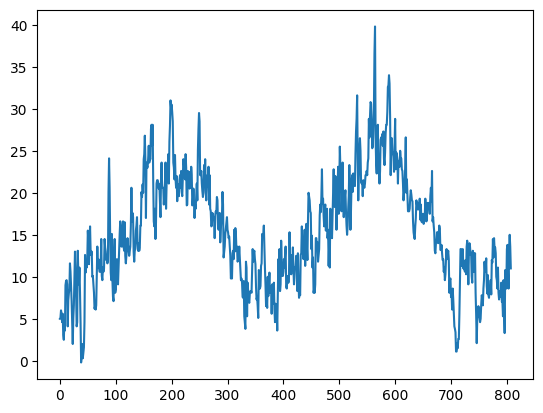

In [2]:
df = read_csv('london_2021-01-01_to_2023-03-19.csv', usecols=[1])
plt.plot(df)
df.head()

In [49]:
data = df.values
data = data.astype('float32') #COnvert values to float
data[:5]

array([[5. ],
       [5.1],
       [6. ],
       [5.6],
       [4.6]], dtype=float32)

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data = scaler.fit_transform(data)
data[:5]

array([[0.13  ],
       [0.1325],
       [0.155 ],
       [0.145 ],
       [0.12  ]], dtype=float32)

In [51]:
train_size = int(len(data) * 0.6)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:,:]
print(f'data shape: {data.shape}, train shape: {train.shape}, test.shape: {test.shape}')

data shape: (808, 1), train shape: (484, 1), test.shape: (324, 1)


In [52]:
def to_sequences(dataset, seq_size):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        x.append(dataset[i:(i+seq_size), 0])
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

### Divide data into sequences of inputs and outputs
x(t-3)-> x(t-2)-> x(t-1)-> x(t) into x1, x2, x3 -> y

In [97]:
seq_size = 5

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print(f'trainX shape: {trainX.shape}, trainY shape: {trainY.shape}, train.shape: {train.shape}')

trainX shape: (478, 5), trainY shape: (478,), train.shape: (484, 1)


In [98]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()
print('Train...')

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, None, 50)          11200     
                                                                 
 lstm_36 (LSTM)              (None, 50)                20200     
                                                                 
 dense_38 (Dense)            (None, 32)                1632      
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 33,065
Trainable params: 33,065
Non-trainable params: 0
_________________________________________________________________
Train...


In [99]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
15/15 - 4s - loss: 0.1104 - val_loss: 0.1031 - 4s/epoch - 299ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0376 - val_loss: 0.0308 - 103ms/epoch - 7ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0176 - val_loss: 0.0222 - 99ms/epoch - 7ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0165 - val_loss: 0.0245 - 98ms/epoch - 7ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0136 - val_loss: 0.0163 - 94ms/epoch - 6ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0105 - val_loss: 0.0107 - 107ms/epoch - 7ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0073 - val_loss: 0.0073 - 98ms/epoch - 7ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0054 - val_loss: 0.0048 - 95ms/epoch - 6ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0045 - val_loss: 0.0046 - 96ms/epoch - 6ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0044 - val_loss: 0.0046 - 96ms/epoch - 6ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0043 - val_loss: 0.0044 - 97ms/epoch - 6ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0044 - val_loss: 0.0041 - 105ms/epoch - 7ms/step
Epoch 13/100
15/15 - 0

In [100]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict_scaled = scaler.inverse_transform(trainPredict)
trainY_scaled = scaler.inverse_transform([trainY])
testPredict_scaled = scaler.inverse_transform(testPredict)
testY_scaled = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_scaled[0], trainPredict_scaled[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_scaled[0], testPredict_scaled[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

10/10 [==============================] - 0s 3ms/step
Train Score: 2.34 RMSE
Test Score: 2.30 RMSE


In [15]:
[testY_scaled[0][:10], [testPredict[:10]]]

[array([28.10000119, 28.10000119, 29.59999974, 32.59999921, 32.79999902,
        34.00000024, 32.99999883, 29.10000022, 22.09999985, 25.29999913]),
 [array([[26.193893],
         [27.992825],
         [30.130167],
         [30.633018],
         [30.12296 ],
         [29.808237],
         [29.829119],
         [31.04049 ],
         [31.159012],
         [26.783344]], dtype=float32)]]

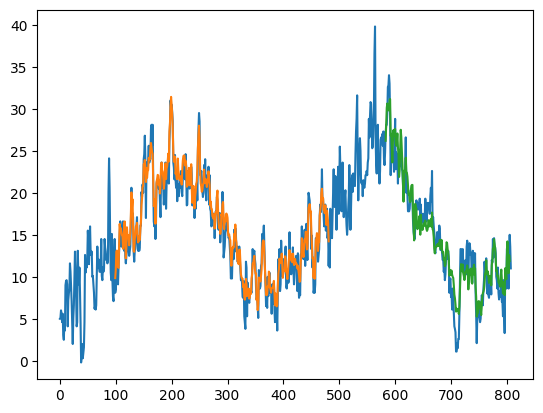

In [16]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size-1:len(trainPredict)+seq_size-1, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2):len(data)-2, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)


# plt.xlim(600,700)
plt.show()